<a href="https://colab.research.google.com/github/FelixKras/CSVParserForDataReduction/blob/master/DataMining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
from collections import Counter
from datetime import date, timedelta, datetime
from difflib import SequenceMatcher
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import urllib.request
import seaborn as sns
import re
import operator
from string import punctuation
import nltk
from nltk import word_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.collocations import ngrams


In [97]:
Data = pd.read_csv('https://raw.githubusercontent.com/FelixKras/CSVParserForDataReduction/master/Data/NewCSV.csv')

#Data.insert(17, 'Survivability', Data["Total Fatalities"].count)
#Data["Survivability"] = round(10 * (Data["TotalAboard"] - Data["Total Fatalities"]) / Data["TotalAboard"])

#clean inf values
Data=Data[~Data.Survivability.isin([np.inf,-np.inf])]

Data.columns = Data.columns.str.lower()

# removing the irrelevant columns
cols_to_drop = ["flightnum","route","registration","cn_ln"]
Data = Data.drop(columns=cols_to_drop)

Data = Data.replace(r'^\?$', np.nan, regex=True)
Data=Data.dropna()
Data.info()
Data.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4502 entries, 0 to 4618
Data columns (total 14 columns):
date                    4502 non-null object
time                    4502 non-null object
location                4502 non-null object
operator                4502 non-null object
ac_type                 4502 non-null object
passengers              4502 non-null int64
crew                    4502 non-null int64
totalaboard             4502 non-null int64
crew fatalities         4502 non-null int64
passenger fatalities    4502 non-null int64
total fatalities        4502 non-null int64
ground fatalities       4502 non-null int64
summary                 4502 non-null object
survivability           4502 non-null int64
dtypes: int64(8), object(6)
memory usage: 527.6+ KB


,date,time,location,operator,ac_type,passengers,crew,totalaboard,crew fatalities,passenger fatalities,total fatalities,ground fatalities,summary,survivability
0,5/1/1950,0:01,Sverdlovsk Russia,Military - Soviet Air Force,Lisunov Li-2,0,0,19,0,0,19,0,During the approach to Koltsovo Airport in Sv...,0
1,18/01/1950,0:01,Albacete Spain,Ejercito del Aire,Junkers JU-52/3m,0,0,16,0,0,16,0,The military plane crashed on the southeast co...,0


In [98]:
Stats=pd.DataFrame(Data[['totalaboard','crew fatalities','passenger fatalities','total fatalities','ground fatalities','survivability']])
Stats.describe()


,totalaboard,crew fatalities,passenger fatalities,total fatalities,ground fatalities,survivability
count,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000,4502.000000
mean,31.518880,3.263883,18.023323,22.563305,1.812084,1.765660
std,47.302437,3.217803,34.827236,36.547569,58.251981,3.108272
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,0.000000,3.000000,0.000000,0.000000
50%,14.000000,2.000000,5.000000,10.000000,0.000000,0.000000
75%,36.000000,5.000000,20.000000,25.000000,0.000000,2.000000
max,644.000000,33.000000,560.000000,583.000000,2750.000000,10.000000


In [99]:
include =['object'] 
Data.describe(include = include)

,date,time,location,operator,ac_type,summary
count,4502,4502,4502,4502,4502,4502
unique,4051,1027,3710,2437,2156,4381
top,31/08/1988,0:01,Moscow Russia,Aeroflot,Douglas DC-3,Crashed during takeNear.
freq,4,1362,16,244,246,9


In [100]:
counts = Counter(Data["operator"])
operators, numOfCrashes = zip(*counts.items())

# sort the values in descending order
indSort = np.argsort(numOfCrashes)[::-1]

# rearrange the data
operators = np.array(operators)[indSort]
values = np.array(numOfCrashes)[indSort]

indexes = np.arange(len(operators))
operators[:5]



array(['Aeroflot', 'Military - U.S. Air Force', 'Indian Airlines',
       'Air Taxi', 'Air France'], dtype='<U60')

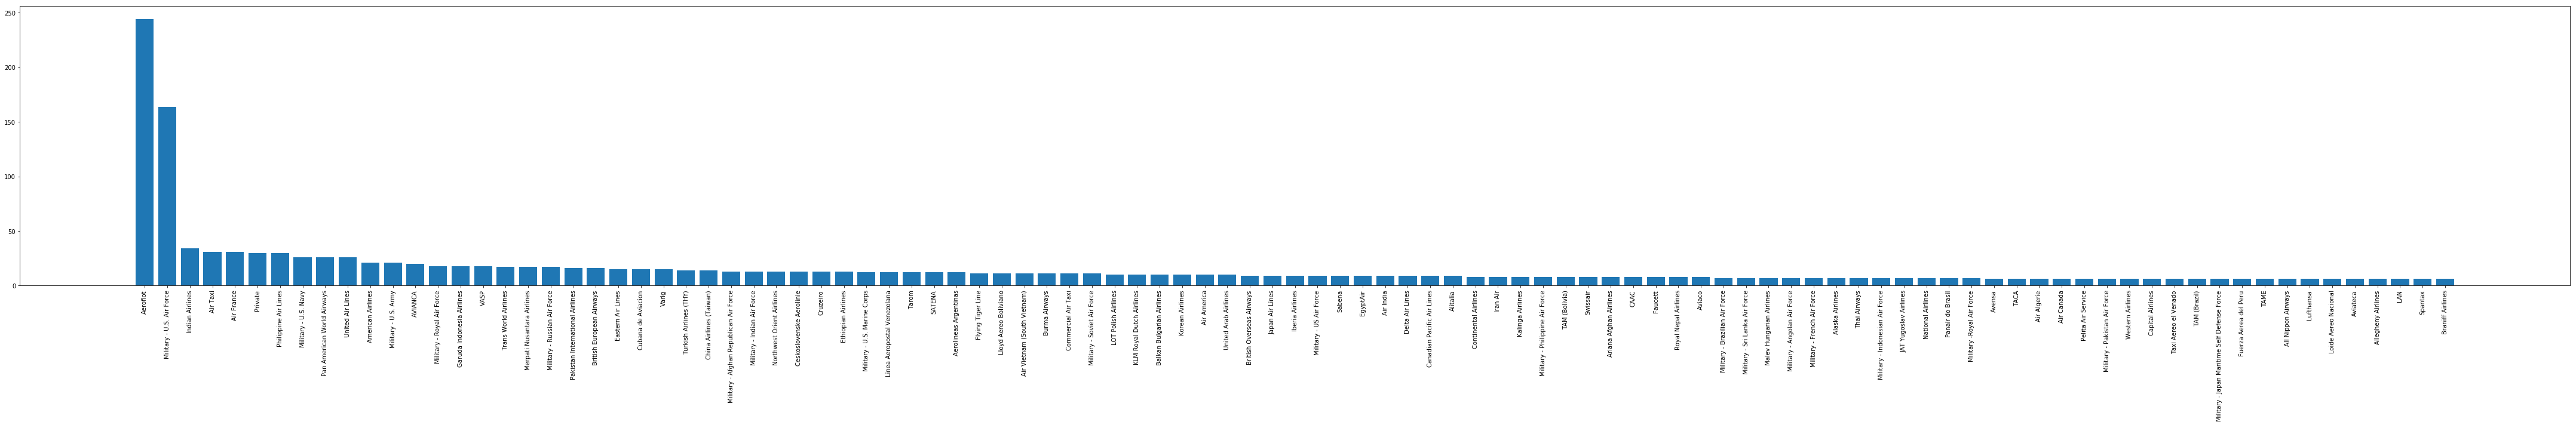

In [101]:
bar_width = 10
maxCountofOperators=len(values[values>5])

plt.bar(indexes[:maxCountofOperators], values[:maxCountofOperators])
plt.rcParams['figure.figsize'] =[60,10]
plt.xticks(indexes[:maxCountofOperators] , operators[:maxCountofOperators], rotation='vertical')
plt.tight_layout()
plt.savefig("operators")
plt.show()


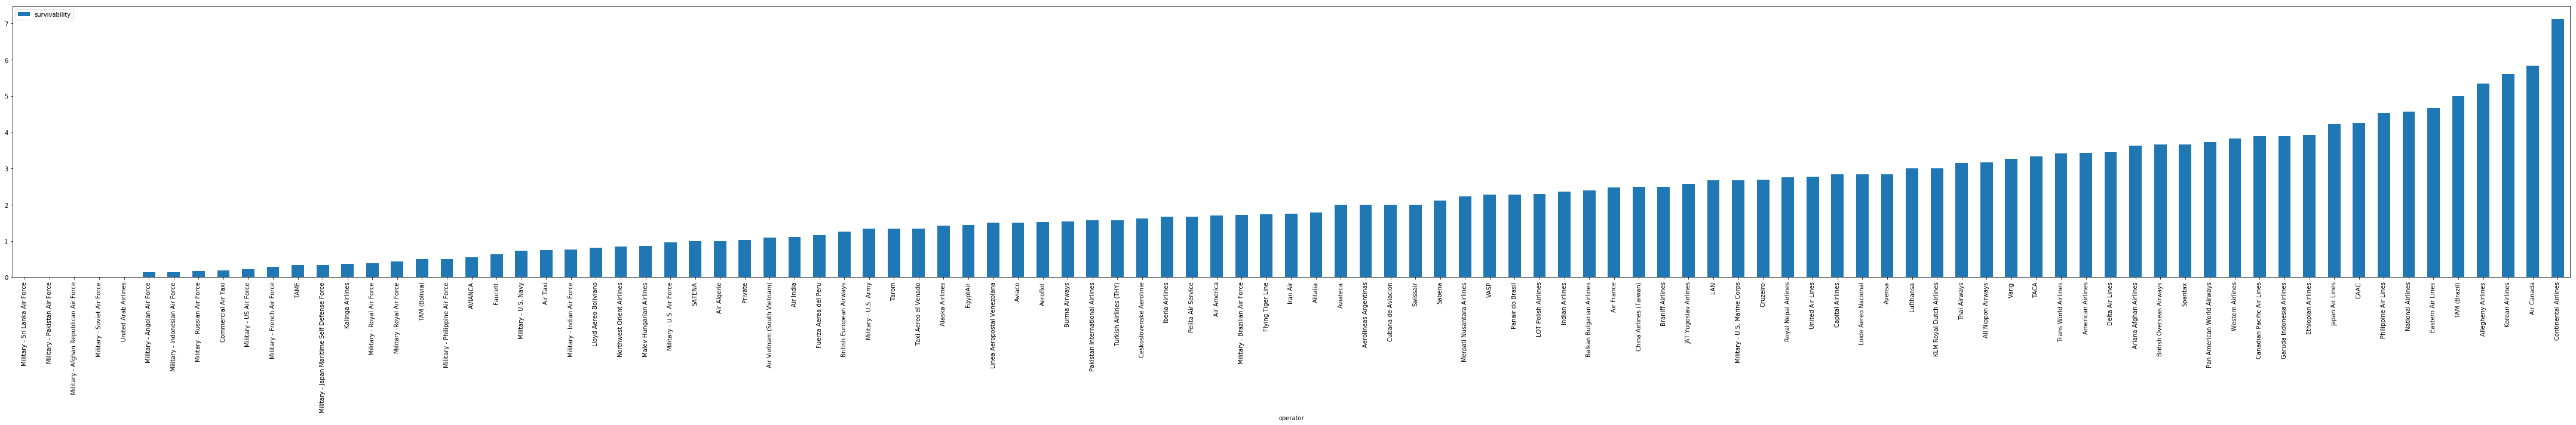

In [102]:
NewData=Data[Data.operator.isin(operators[:maxCountofOperators])]
df = pd.DataFrame(NewData[['operator','survivability']])
df=df[~df.survivability.isin([np.inf,-np.inf])] #drop inf values because of zero denominator

dsurvive = pd.DataFrame(df.groupby('operator', as_index=False).mean())
dsurvive = dsurvive.sort_values('survivability', ascending=True)
dsurvive.plot(x='operator', kind='bar')
plt.rcParams['figure.figsize'] =[60,10]
#print(dsurvive)
plt.tight_layout()
plt.savefig('survivability')




causes not avaiable: 4502
unindentified causes: 2998
engine failure 405
poor weather 384
stall 271
pilot error 174
on fire 116
turbulence 107
shot down 99
fuel exhaustion 57
electrical problem 47
terrorism 46
structure failure 36


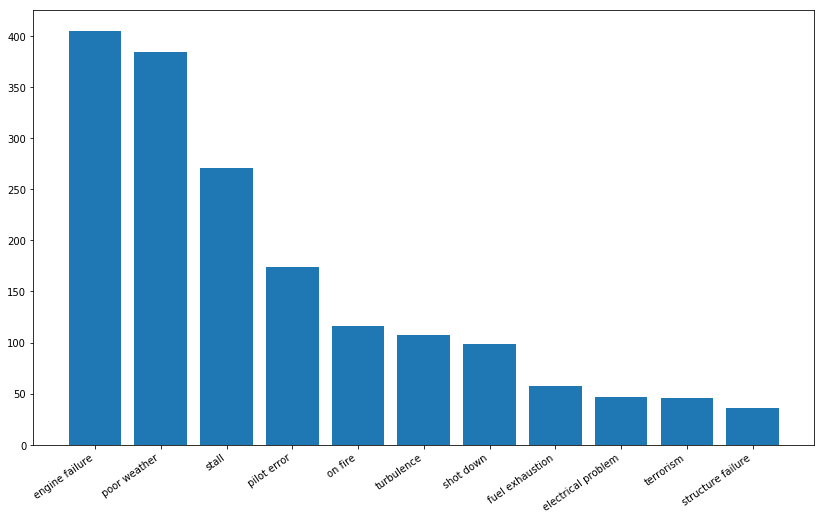

In [103]:
failures = {
    'pilot error': '(pilot|crew) (error|fatigue)',
    'engine failure': 'engine.*(fire|fail)',
    'structure failure': '(structural fail)|(fuel leak)|(langing gear)',
    'electrical problem': 'electrical',
    'poor weather': '((poor|bad).*(weather|visibility)|thunderstorm)',
    'stall': 'stall',
    'on fire': '(caught fire)|(caught on fire)',
    'turbulence': 'turbulence',
    'fuel exhaustion': '(out of fuel)|(fuel.*exhaust)',
    'terrorism': 'terrorist|terrorism|hijack|exploded in midair',
    'shot down': 'shot down',
}

failure_counts = {'other':0}

for s in Data.summary.dropna():
    other = True
    for failure, exp in failures.items():
        if re.search(exp, s.lower()):
            other = False
            if failure in failure_counts:
                failure_counts[failure] += 1
            else:
                failure_counts[failure] = 1
    if other:
        failure_counts['other'] += 1

nan_counts = len(Data.summary.isnull())
print('causes not avaiable: %d' % nan_counts)
print('unindentified causes: %d' % failure_counts['other'])

del failure_counts['other']

sortedcauses = sorted(failure_counts.items(), key=operator.itemgetter(1), reverse=True)
for k, v in sortedcauses:
    print(k, v)

plt.figure(figsize=(14, 8))
x, y = zip(*sortedcauses)
plt.bar(x,y)
plt.xticks(rotation=35, horizontalalignment='right')
plt.show()

Text(0, 0.5, 'chance of survival')

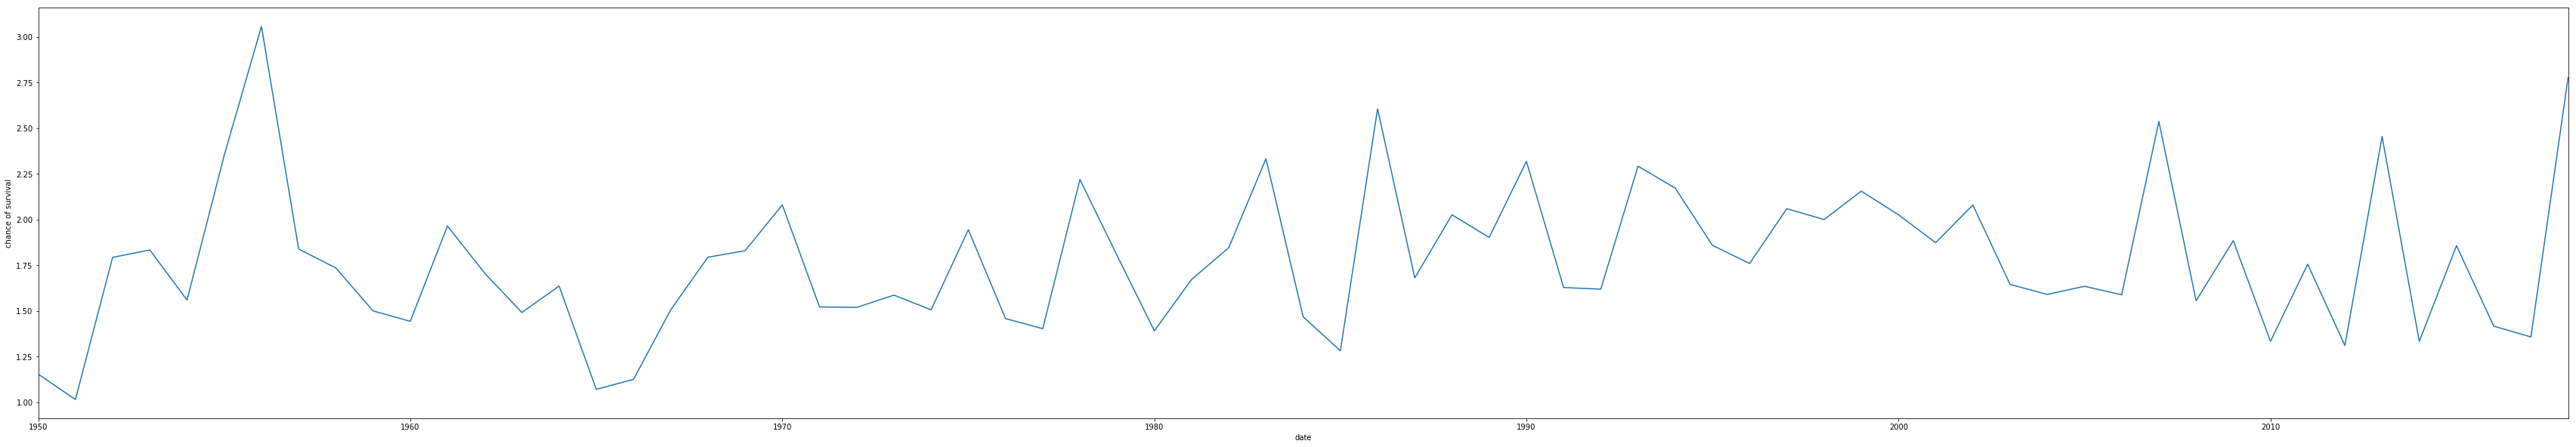

In [104]:
Data['date']=pd.to_datetime(Data['date'])
survivability_series=Data.groupby(Data['date'].dt.year)['survivability'].mean()
survivability_series=pd.Series(survivability_series,index=survivability_series.index)
survivability_series.dropna().plot()
plt.ylabel('chance of survival')

douglas      803
boeing       360
cessna       320
OTHER        303
antonov      286
lockheed     260
havilland    253
beech        167
ilyushin     139
piper        136
Name: plane_type, dtype: int64


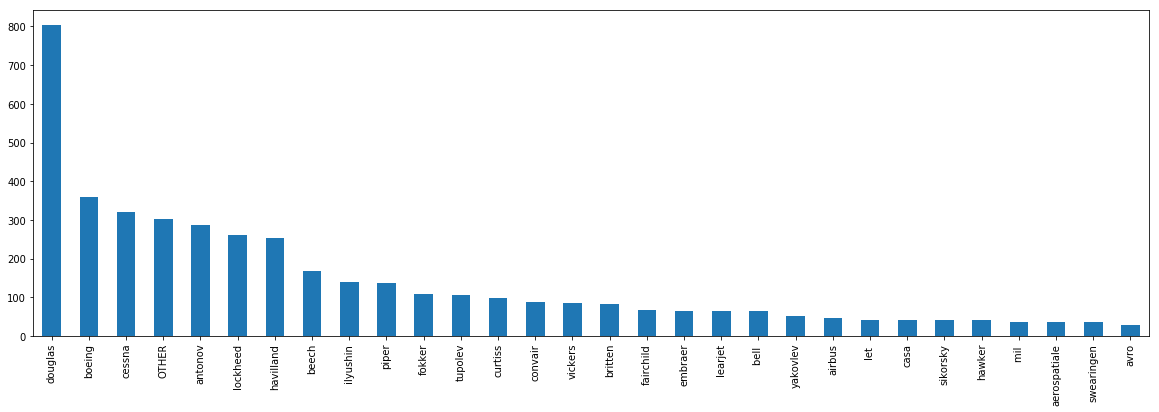

In [105]:
def type_extractor(x):
    plane_types = [
        'douglas', 'havilland', 'antonov', 'yakovlev', 'junkers', 'breguet', 'curtiss', 'embraer',
        'fokker', 'tupolev', 'lockheed', 'cessna', 'boeing', 'piper', 'britten', 'ilyushin', 'airship',
        'sikorsky', 'bristol', 'casa', 'convair', 'vickers', 'fairchild', 'consolidated', 'hawker', 'let ',
        'mil ', 'martin', 'airbus', 'bell ', 'learjet', 'avro', 'short', 'aerospatiale', 'beech', 'swearingen', 
        'british aerospace', 'canadair', 'farman ', 'aero commander', 'bac ',
        'dornier', 'ford', 'grumman', 'handley', 'latecoere', 'mi-', 'rockwell', 'sud'
    ]
    for name in plane_types:
        if name in x:
            return name
    return 'OTHER'

Data['ac_type'].fillna('not_known', inplace=True)
Data['ac_type'] = Data['ac_type'].str.lower()
Data['plane_type'] = Data['ac_type'].apply(type_extractor)

plt.figure(figsize=(20, 6))
Data['plane_type'].value_counts()[:30].plot('bar')
print(Data['plane_type'].value_counts()[:10])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


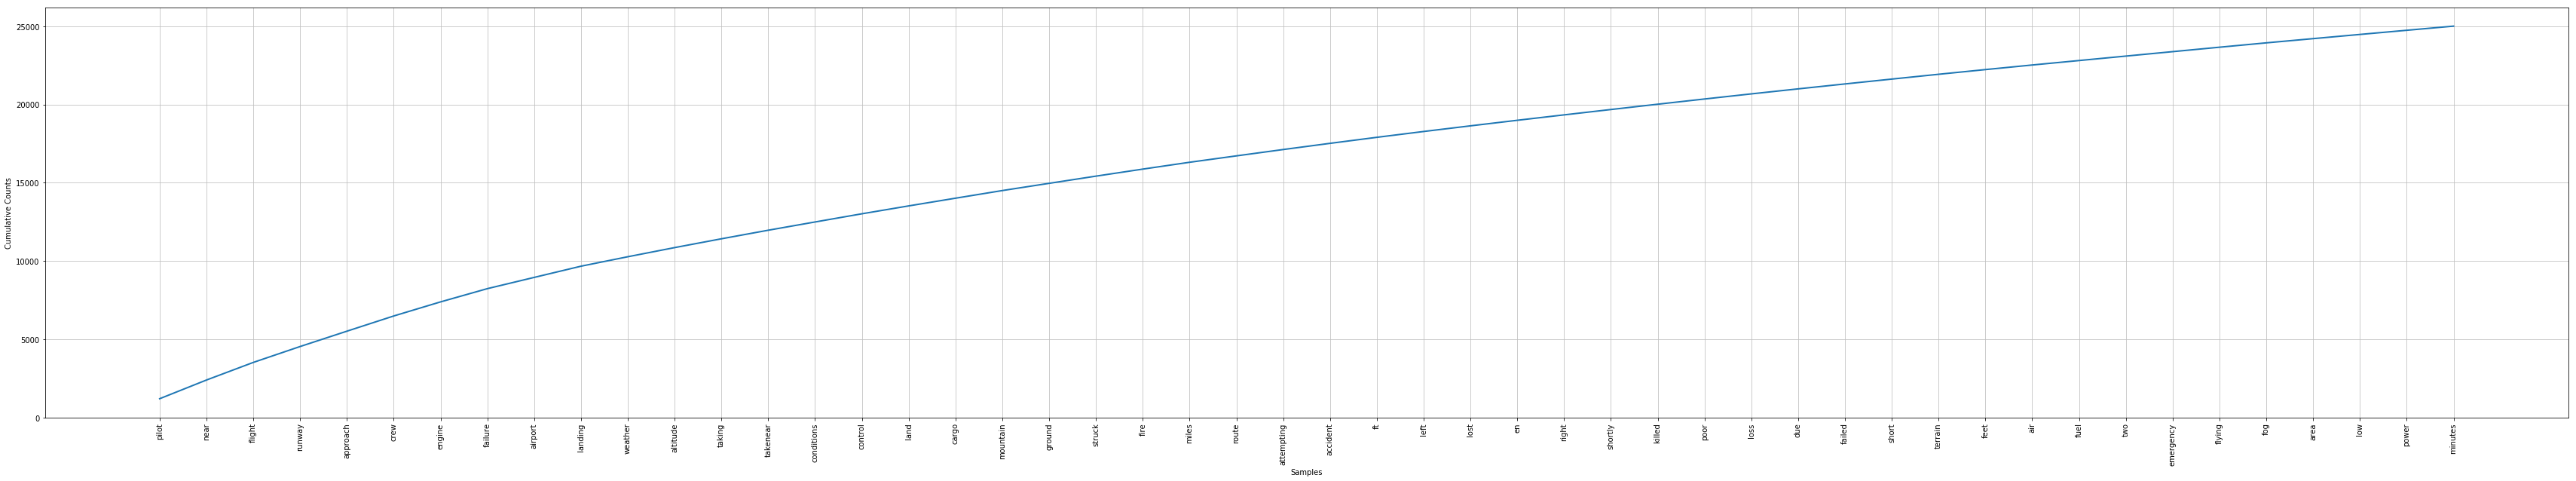

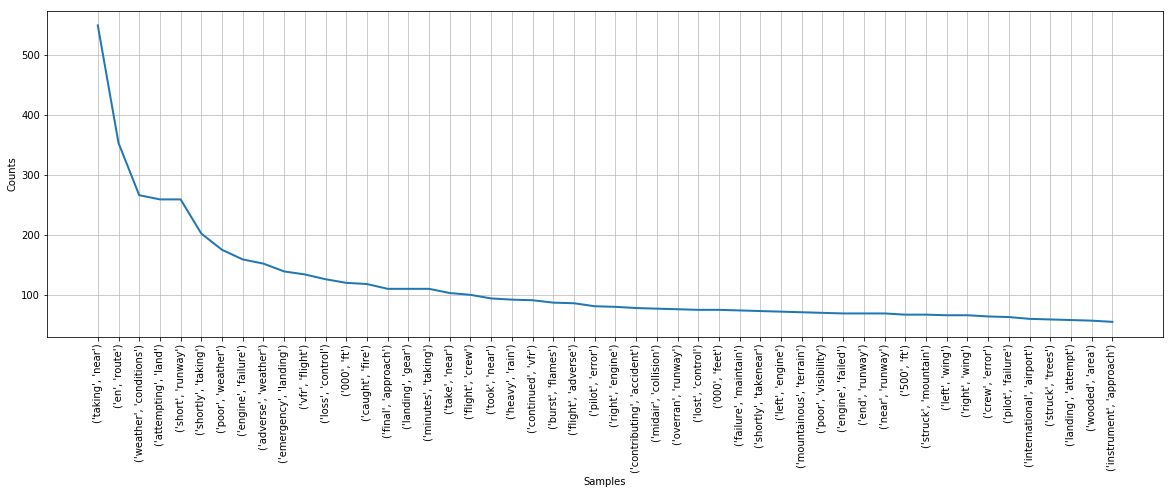

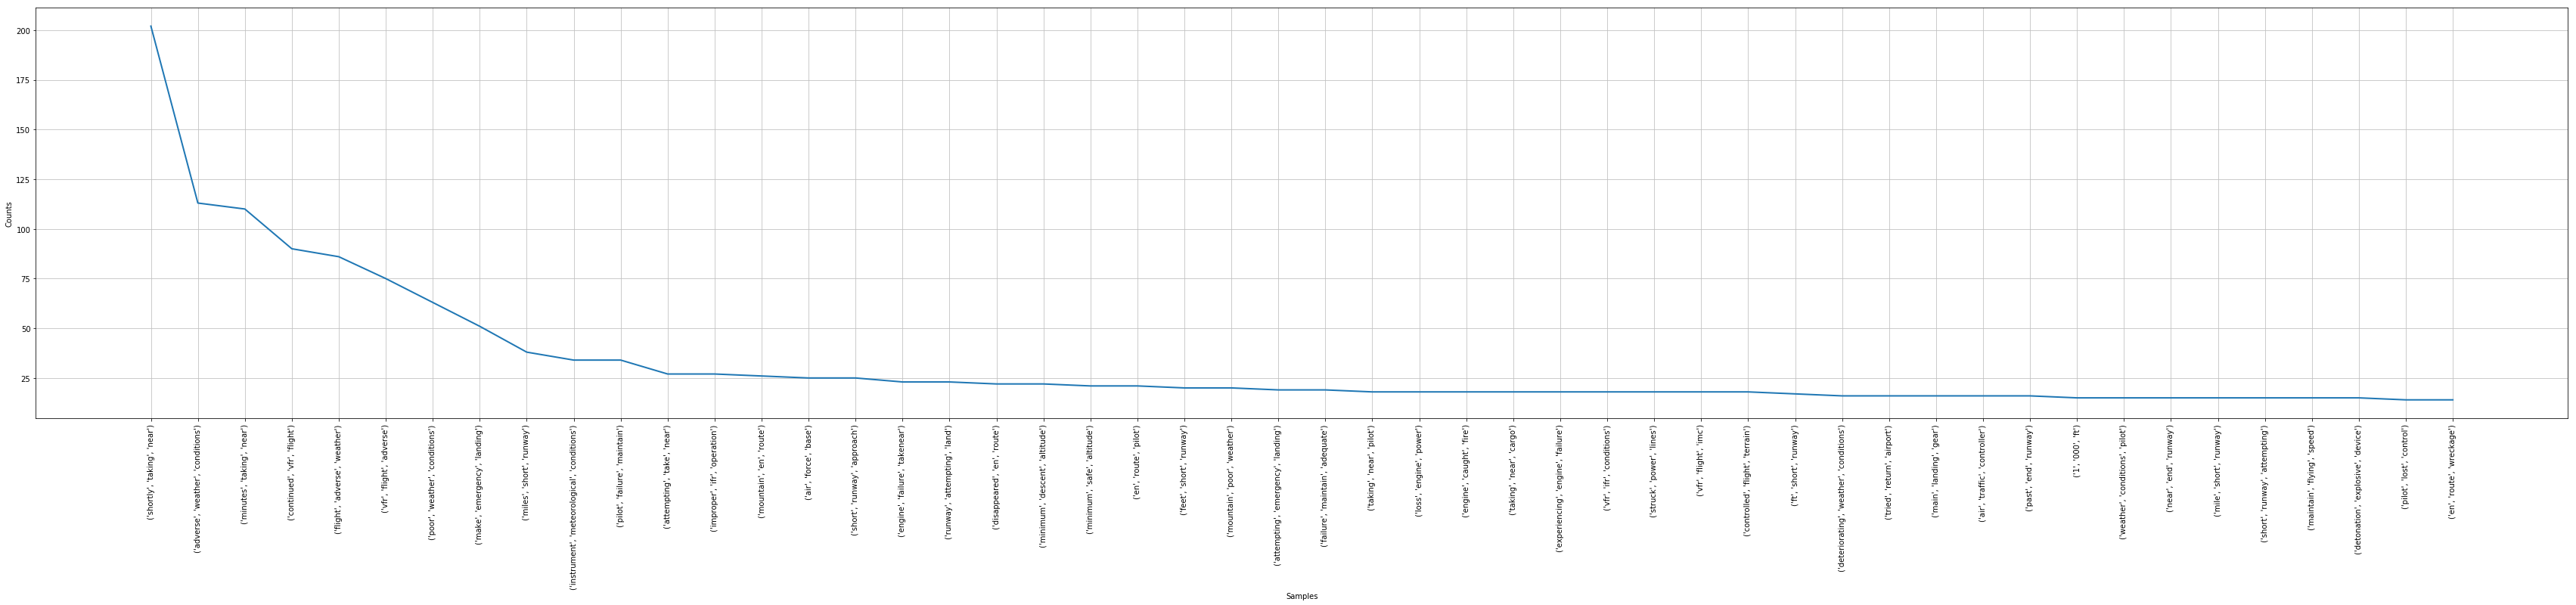

<Figure size 4320x720 with 0 Axes>

In [106]:

def remove_punctuation(s):
    exclude = set(string.punctuation)
    s = ''.join([i for i in s if i not in exclude])
    return s

nltk.download('stopwords')
stop = stopwords.words('english')
stop.append('plane')
stop.append('crashed')
stop.append('aircraft')

t = Data[['summary','survivability']].dropna()
book = t['summary'].str.lower().apply(remove_punctuation).str.split().values.sum()
wrd = [w for w in book if w not in stop]

fdist = FreqDist(wrd)
fdist.plot(50,cumulative = True)
plt.figure(figsize=(20, 6))

bigramsLst = list(ngrams(wrd,2))
fdistBigram = FreqDist(bigramsLst)
fdistBigram.plot(50)

trigramsLst = list(ngrams(wrd,3))
fdistTrigram = FreqDist(trigramsLst)
fdistTrigram.plot(50)


plt.tight_layout
plt.savefig('main_facotrs')